In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from google.colab import files
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [ ]:
from  sklearn.feature_selection import mutual_info_classif

In [ ]:
import seaborn as sns

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/kozaka93/2023Z-AutoML/main/homeworks/homework2/artificial_train.data", sep = " ", header = None)
y = pd.read_csv("https://raw.githubusercontent.com/kozaka93/2023Z-AutoML/main/homeworks/homework2/artificial_train.labels", header = None)

In [ ]:
df = df.drop(500, axis = 1)
df["y"] = y

In [ ]:
X = df.drop("y", axis = 1)

**Analiza Eksploracyjna danych**

In [ ]:
np.unique(y) #Mamy dwie klasy -1 i  1 przy niektórych modelach możliwe że trzeba będzie to wziąć pod uwagę

array([-1,  1])

In [ ]:
print(np.sum(np.array(y) == -1)) #1000 obserwacji
print(np.sum(np.array(y) == 1)) #1000 obserwacji klasy są rozłożone równomiernie

1000
1000


In [ ]:
print(X.shape) #2000 obserwacji i 500 zmiennych

(2000, 500)


In [ ]:
np.unique(X.dtypes)

array([dtype('int64')], dtype=object)

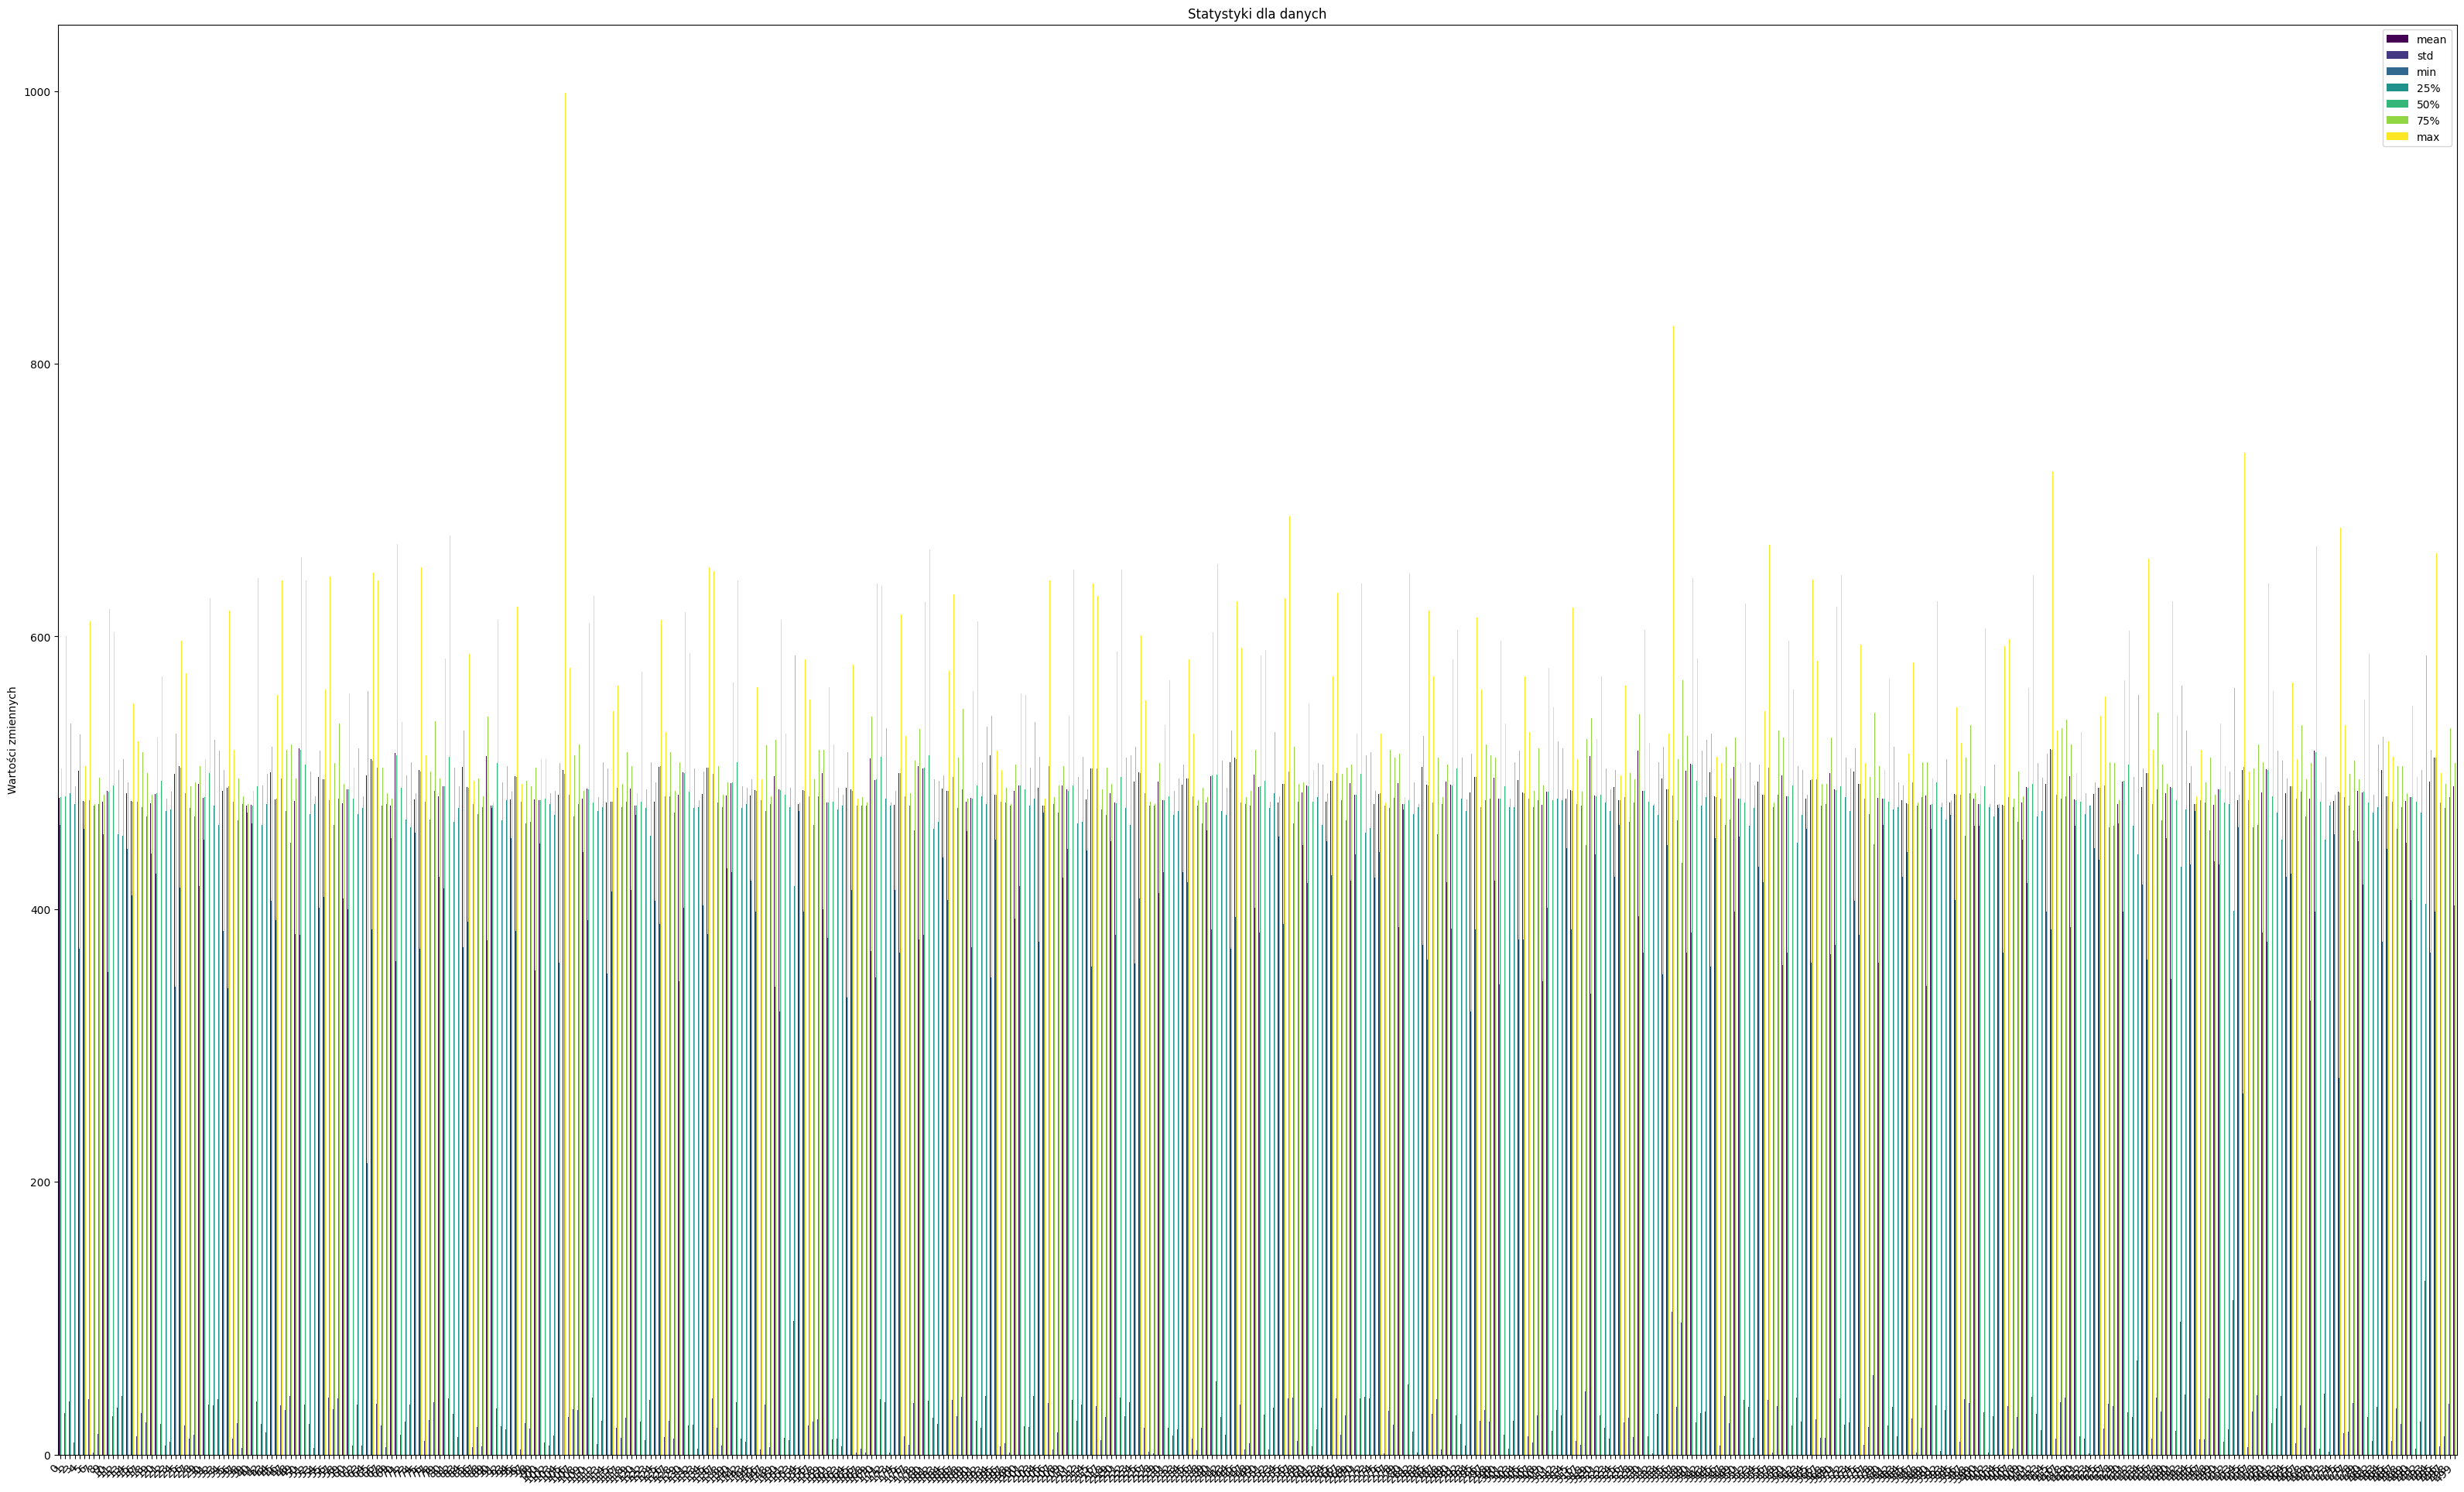

In [ ]:
summary_stats = X.describe().drop('count')

summary_stats = summary_stats.transpose()
max_var_name_length = 10
fig, ax = plt.subplots(figsize=(40, 24))
summary_stats.plot(kind='bar', ax=ax, colormap='viridis')

ax.set_xticklabels(summary_stats.index, rotation=45, ha='right')

ax.set_ylabel('Wartości zmiennych')
ax.set_title('Statystyki dla danych')

plt.show()


Wykres jest bardzo nieczytelny, ale na pierwszy rzut oka wygląda na to, że zmienne mają podobną skalę.


<function matplotlib.pyplot.show(close=None, block=None)>

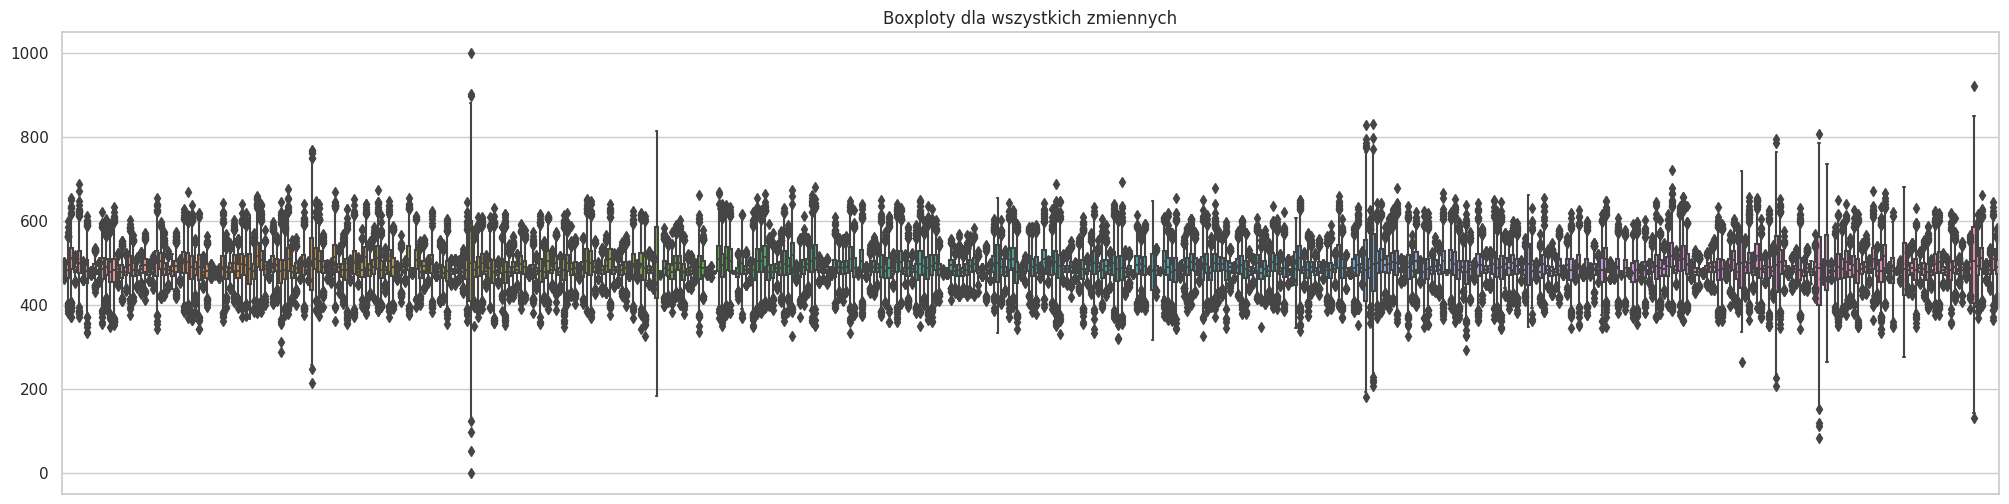

In [ ]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (25,6))
sns.boxplot(data = X[X.columns])
plt.xticks([])
plt.title("Boxploty dla wszystkich zmiennych")
plt.show

Na tym wykresie lepiej widać, że większość zmiennych jest skoncentrowana wokół podobnych wartości więc raczej nie ma potrzeby skalowania ich.

In [ ]:
np.unique(X.isnull().sum(axis=0)) #nie mamy braków danych

array([0])

##Podział danych na zbiór treningowy i testowy

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2023)

## Eliminacja **outlierów**
Korzystamy z metody opartej o rozstęp międzykwartylowy. Po zerknięciu na boxploty nie mamy podstaw, aby sądzić, że mamy do czynienia ze skośnymi rozkładami. Jeżeli procent outlierów nie będzie zbyt duży, to je usuniemy, w przeciwnym przypadku outliery zostaną zastąpione przez wartości trzeciego lub pierwszego kwantyla.



In [ ]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = np.where(df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))])
   return outliers

In [ ]:
outliers = []
for i in X_train.columns:
  outliers.append(np.array(find_outliers_IQR(X[i])).flatten())

outliers = np.concatenate(outliers)

print(len(np.unique(outliers)))
print(len(outliers)/(len(X[1])*500))

748
0.010385


Gdybyśmy chcieli usunąć rekordy z brakami danych stracilbyśmy ponad 1/4 obserwacji. Jeśli jednak zdecydujemy się na zmianę obserwacji odstających zmienimy jedynie 1% wszystkich wartości. Decydujemy się na podejście drugie.

In [ ]:
def remove_outliers_IQR(df):
  df_copy = df.copy()
  for columns in df.columns:
    q1=df[columns].quantile(0.25)
    q3=df[columns].quantile(0.75)
    IQR=q3-q1
    df_copy.loc[df_copy[columns] < (q1 - 1.5 * IQR), columns] = q1
    df_copy.loc[df_copy[columns] > (q3 + 1.5 * IQR), columns] = q3
  return df_copy

In [ ]:
X_train = remove_outliers_IQR(X_train)

## Selekcja zmiennych

 1 **Mututal Information** Selekcja zmiennych oparta o podejście z teorii informacji.

In [ ]:
mutual_info = pd.DataFrame(mutual_info_classif(X_train, y_train, copy = True, random_state = 2023, n_neighbors = 2))

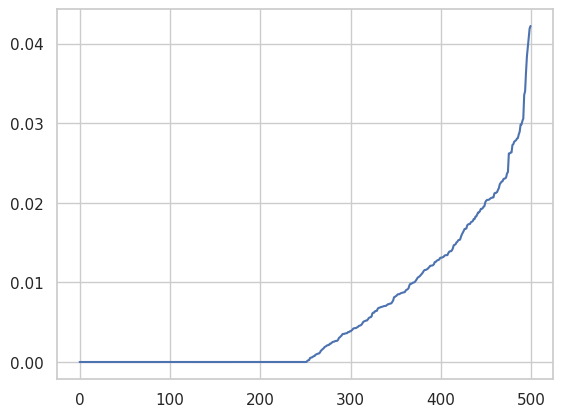

In [ ]:
plt.plot(np.sort(np.concatenate(np.array(mutual_info))))

In [ ]:
np.max(mutual_info)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


0    0.042202
dtype: float64

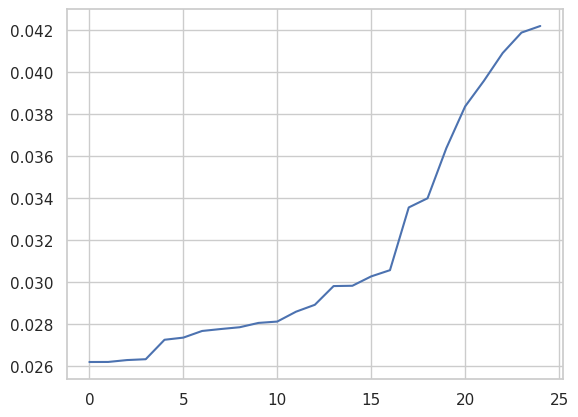

In [ ]:
plt.plot(np.sort(np.concatenate(np.array(mutual_info[mutual_info>0.025].dropna()))))

In [ ]:
X_mutual_info = X_train.loc[:,np.array(mutual_info>0.025).flatten()]

<Axes: >

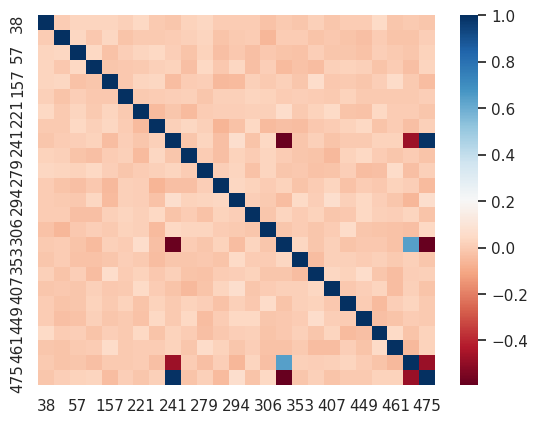

In [ ]:
sns.heatmap(X_mutual_info.corr(), cmap='RdBu') #widzimy, że niektóre zmienne mają dosyć silną korelację, można rozważyć usunięcie

In [ ]:
def remove_correlated_features(df, threshold):
  """
  Usuwa po jednej kolumnie z pary tych kolumn w ramce danych X, które mają współczynnik korelacji co do modułu większy niż threshold.

  Args:
    X: Ramka danych.
    threshold: Granica współczynnika korelacji.

  Returns:
    Ramka danych z usuniętymi kolumnami.
  """

  # Oblicz współczynniki korelacji
  X = df.copy()
  corr = X.corr()
  colnames = X.columns
  # Znajdź pary kolumn o wysokim współczynniku korelacji
  to_remove = []
  for i in range(len(corr)):
    for j in range(i + 1, len(corr)):
      if abs(corr.values[i, j]) > threshold:
        to_remove.append(colnames[i])
  to_remove = np.unique(to_remove)

  # Usuń po jednej kolumnie z każdej pary
  for idx in to_remove:
    X = X.drop(columns=idx, axis = 1)

  return X


In [ ]:
X_mutual_info_corr = remove_correlated_features(X_mutual_info, 0.7)

In [ ]:
print(X_mutual_info.shape)
print(X_mutual_info_corr.shape) #usuwamy w ten sposób niewiele zmiennych - zignorujemy temat

(1600, 25)
(1600, 24)


<Axes: >

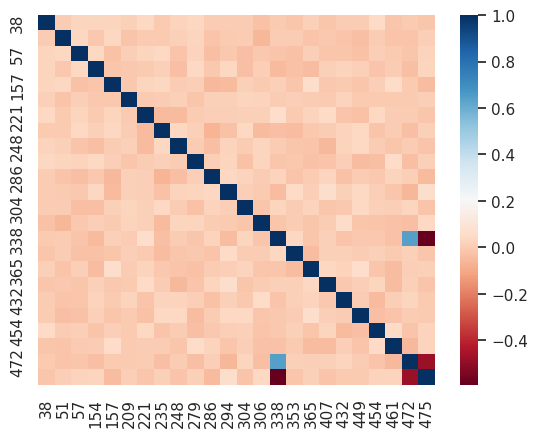

In [ ]:
sns.heatmap(X_mutual_info_corr.corr(), cmap='RdBu') #niewiele się zmieniło

In [ ]:
selected_columns_mutual_information = X_train.columns[np.array(mutual_info>0.03).flatten()]

2.**Boruta** - selekcja zmiennych oparta o model boruta

In [ ]:
!pip install Boruta
from boruta import BorutaPy

In [ ]:
X_train_boruta = X_train.values
y_train_boruta = y_train.values

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_boruta, y_train_boruta)

In [ ]:
feat_selector = BorutaPy(rf_model, n_estimators='auto', verbose=2, random_state=0)
feat_selector.fit(X_train_boruta, y_train_boruta)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	476


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	9 / 100
Confirmed: 	14
Tentative: 	10
Rejected: 	476


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	10 / 100
Confirmed: 	14
Tentative: 	10
Rejected: 	476


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	11 / 100
Confirmed: 	14
Tentative: 	10
Rejected: 	476


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	12 / 100
Confirmed: 	18
Tentative: 	6
Rejected: 	476


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	13 / 100
Confirmed: 	18
Tentative: 	5
Rejected: 	477


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	14 / 100
Confirmed: 	18
Tentative: 	5
Rejected: 	477


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	15 / 100
Confirmed: 	18
Tentative: 	5
Rejected: 	477


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	16 / 100
Confirmed: 	18
Tentative: 	4
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	17 / 100
Confirmed: 	18
Tentative: 	4
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	18 / 100
Confirmed: 	18
Tentative: 	4
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	19 / 100
Confirmed: 	19
Tentative: 	3
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	20 / 100
Confirmed: 	19
Tentative: 	3
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	21 / 100
Confirmed: 	19
Tentative: 	3
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	22 / 100
Confirmed: 	19
Tentative: 	3
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	23 / 100
Confirmed: 	19
Tentative: 	3
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	24 / 100
Confirmed: 	19
Tentative: 	3
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	25 / 100
Confirmed: 	19
Tentative: 	3
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	26 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	27 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	28 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	29 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	30 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	31 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	32 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	33 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	34 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	35 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	36 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	37 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	38 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	39 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	40 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	41 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	42 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	43 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	44 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	45 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	46 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	47 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	48 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	49 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	50 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	51 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	52 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	53 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	54 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	55 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	56 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	57 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	58 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	59 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	60 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	61 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	62 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	63 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	64 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	65 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	66 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	67 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	68 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	69 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	70 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	71 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	72 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	73 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	74 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	75 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	76 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	77 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	78 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	79 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	80 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	81 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	82 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	83 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	84 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	85 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	86 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	87 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	88 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	89 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	90 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	91 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	92 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	93 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	94 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	95 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	96 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	97 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	98 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	99 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	20
Tentative: 	0
Rejected: 	478


BorutaPy(estimator=RandomForestClassifier(n_estimators=66,
                                          random_state=RandomState(MT19937) at 0x7B947DC7BB40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7B947DC7BB40, verbose=2)

In [ ]:
selected_columns_boruta = X_train.columns[feat_selector.support_]

In [ ]:
len(selected_columns_boruta)

20

3.**Lasso** - wybór zmiennych oparty o regularyzację L1

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
lasso_model = Lasso(random_state=42)
lasso_model.fit(X_train, y_train)
sfm = SelectFromModel(lasso_model, threshold='mean')
X_train_selected = sfm.fit_transform(X_train, y_train)

selected_columns_lasso_y = X_train.columns[sfm.get_support()]
print("Wybrane kolumny:", selected_columns_lasso_y)

Wybrane kolumny: Index([  4,   6,  10,  12,  41,  46,  56,  66,  73, 119, 125, 134, 136, 140,
       149, 199, 204, 211, 221, 224, 245, 277, 285, 286, 296, 329, 333, 336,
       347, 358, 365, 377, 378, 382, 411, 412, 417, 431, 442, 453, 457, 458,
       475, 478, 481, 494],
      dtype='object')


In [ ]:
len(selected_columns_lasso_y)

46

4.**Random Forest Regresor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X_train_selected = X_train.copy()
y_train_selected = y_train.copy()

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_selected, y_train_selected)
sfm = SelectFromModel(rf_model, threshold='mean')
X_train_selected = sfm.fit_transform(X_train_selected, y_train_selected)

selected_columns_randomforrest_y = X_train.columns[sfm.get_support()]
print("Wybrane kolumny:", selected_columns_randomforrest_y)

<ipython-input-44-8d14c11880bc>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_selected, y_train_selected)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_from_model.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


Wybrane kolumny: Index([  2,  10,  17,  18,  28,  48,  64,  77, 105, 118, 128, 134, 141, 144,
       153, 164, 174, 179, 201, 212, 215, 217, 235, 241, 281, 285, 296, 318,
       334, 336, 338, 343, 344, 359, 378, 388, 397, 408, 412, 415, 431, 433,
       442, 449, 451, 453, 455, 472, 475, 493, 495],
      dtype='object')


In [ ]:
print(len(selected_columns_randomforrest_y))

51


5. **Wspołczynnik rang Spearmana**

In [ ]:
from scipy.stats import spearmanr
spearman_results = []

for column_name in X.columns:
    res = spearmanr(X_train[column_name], y_train)
    spearman_results.append((column_name, res.statistic))

In [ ]:
columns, spearman_statistics = zip(*spearman_results)
np.array(spearman_statistics)[np.abs(spearman_statistics)>0.1]

array([ 0.11962798, -0.15826535,  0.13354214,  0.13855913,  0.20783793,
       -0.16423523, -0.1369837 ,  0.11692961,  0.2052514 ])

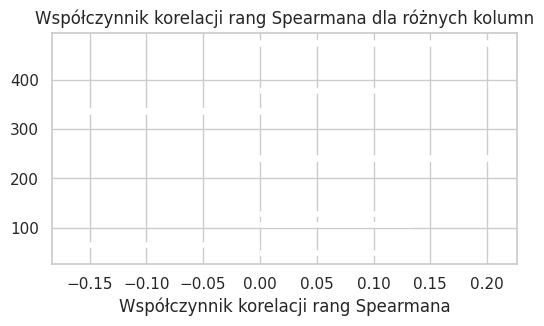

In [ ]:
columns, spearman_statistics = zip(*spearman_results)
filtered_columns = np.array(columns)[np.abs(spearman_statistics) > 0.1]
filtered_statistics = np.array(spearman_statistics)[np.abs(spearman_statistics) > 0.1]

# Tworzenie wykresu z pogrubionymi słupkami
plt.figure(figsize=(6, 3))
plt.barh(filtered_columns, filtered_statistics, color='skyblue', linewidth=4)  # Ustawienie linewidth na 2.5

# Dodanie etykiet i tytułu
plt.xlabel('Współczynnik korelacji rang Spearmana')
plt.title('Współczynnik korelacji rang Spearmana dla różnych kolumn')

# Wyświetlenie wykresu
plt.show()

In [ ]:
selected_columns_spearman = filtered_columns

In [ ]:
print(len(filtered_columns)) #za pomocą współczynnika rang spearmana wybieramy 9 zmiennych

9


6.**XGBoost**

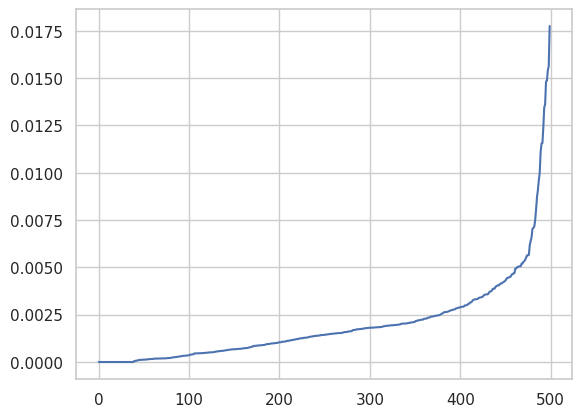

In [ ]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance

# fit model no training data
model = XGBClassifier()
model.fit(X_train, (y_train+1)/2)
# plot feature importance
plt.plot(np.sort(model.feature_importances_))

In [ ]:
selected_columns_xgboost = np.array(X_train.columns)[(np.array(model.feature_importances_) > 0.0075)]

In [ ]:
print(len(selected_columns_xgboost))

17


7.SelectKBest

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression

selector = SelectKBest(score_func=f_regression, k=20)
X_train_kbest1 = X_train.copy()
y_train_kbest = y_train.copy()
X_train_selected = selector.fit_transform(X_train_kbest1, y_train_kbest)
selected_columns_y_kbest = X_train.columns[selector.get_support()]
print("Wybrane kolumny:", selected_columns_y_kbest)

Wybrane kolumny: Index([ 10,  48,  64, 105, 119, 128, 149, 205, 241, 286, 323, 336, 338, 378,
       442, 447, 453, 472, 475, 493],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(len(selected_columns_y_kbest))

20


In [ ]:
selected_columns_xgboost

array([15, 17, 28, 48, 95, 105, 153, 232, 241, 287, 338, 378, 397, 442,
       451, 453, 472], dtype=object)

Porównanie wyników otrzymanych różnymi metodami

In [ ]:
comparison_y1 = pd.DataFrame(0, columns=X_train.columns, index=['MutualInformation', 'Boruta','RandomForest', 'Spearman', 'XGBoost', 'Kbest'])

comparison_y1.loc['MutualInformation', selected_columns_mutual_information] = 1
comparison_y1.loc['Boruta', selected_columns_boruta] = 1
comparison_y1.loc['RandomForest', selected_columns_randomforrest_y] = 1
comparison_y1.loc['Spearman', selected_columns_spearman] = 1
comparison_y1.loc['XGBoost', selected_columns_xgboost] = 1
comparison_y1.loc['Kbest', selected_columns_y_kbest] = 1
comparison_y1

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
MutualInformation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Boruta,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
RandomForest,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
Lasso,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Spearman,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
XGBoost,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kbest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


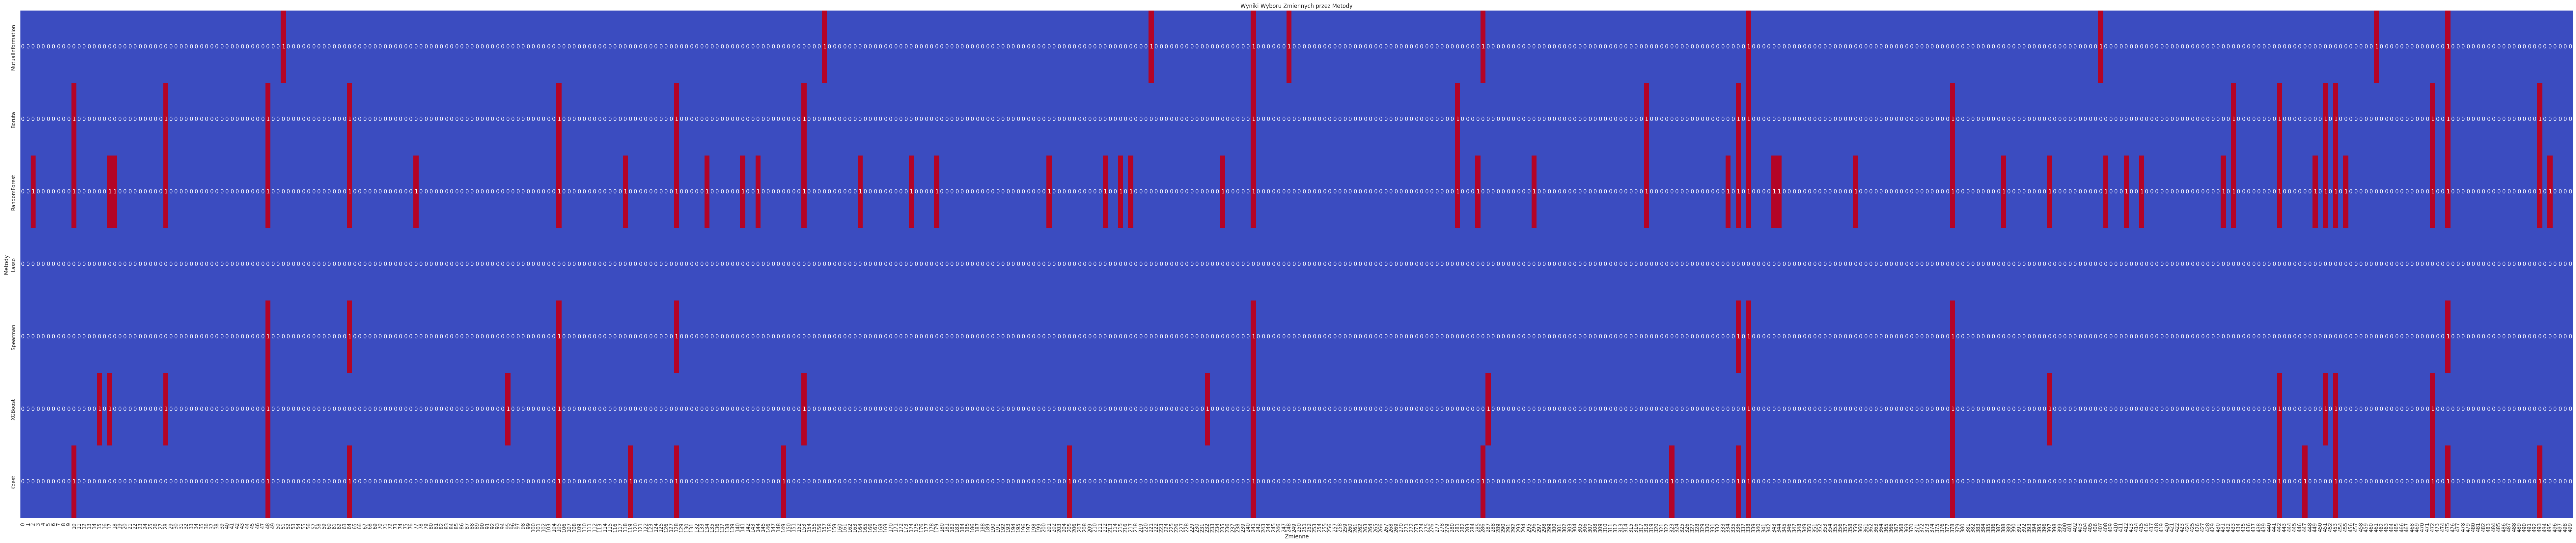

In [ ]:
plt.figure(figsize=(100, 20))
sns.heatmap(comparison_y1, cmap='coolwarm', annot=True, fmt='d', cbar=False)

# Dostosuj etykiety osi
plt.xlabel('Zmienne')
plt.ylabel('Metody')
plt.title('Wyniki Wyboru Zmiennych przez Metody')

# Wyświetl wykres
plt.show()

Wybieramy te zmienne które zostały wybrane przez co najmniej trzy modele

In [ ]:
selected_columns_UC = comparison_y1.columns[comparison_y1.sum() > 2]

In [ ]:
len(selected_columns_UC)

17

In [ ]:
X_train = X_train[selected_columns_UC]

In [ ]:
X_test = X_test[selected_columns_UC]

## Dopasowanie modeli

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

**RandomForest**

In [ ]:
rf = RandomForestClassifier(random_state = 2023)
grid_forest_prep = {
    "n_estimators": [20, 50, 100, 200, 500, 700, 1000, 1500, 2000, 2100, 2500, 3000],
    "min_samples_split": [ 1e-5,1e-4,0.0001, 0.001, 0.01, 0.1],
    "warm_start": [True, False],
    "max_depth": [10, 30, 50, 70, 100,150,200, 500, 1000],
    "min_samples_leaf": [1,2, 3, 5, 10,15,20]
}


In [ ]:
rs_rf = RandomizedSearchCV(rf, grid_forest_prep, cv=5, scoring='balanced_accuracy', random_state = 2023, n_iter = 50, n_jobs=-1)

rs_rf.fit(X_train, y_train)
rf_params=rs_rf.best_params_
res_rf = rs_rf.cv_results_
rf_params=rs_rf.best_params_
print(rf_params)
print(rs_rf.score(X_test, y_test))
score_rf = rs_rf.score(X_test, y_test)
print(res_rf['mean_test_score'])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'warm_start': False, 'n_estimators': 2500, 'min_samples_split': 1e-05, 'min_samples_leaf': 1, 'max_depth': 200}
0.87998799879988
[0.80923508 0.84304409 0.82112585 0.85429826 0.82675488 0.84116128
 0.85556777 0.86306001 0.85429826 0.85869277 0.87245083 0.8687164
 0.82491501 0.86686882 0.84369665 0.86494287 0.8687164  0.8136375
 0.82491501 0.85247407 0.739203   0.84429802 0.82612988 0.74043737
 0.87057578 0.74044513 0.84429021 0.82612988 0.86119287 0.87682991
 0.74044513 0.83803623 0.83243879 0.86684136 0.87682991 0.86994685
 0.86934917 0.83494262 0.85498975 0.86995859 0.87619704 0.87619704
 0.86182956 0.71298376 0.80986396 0.86934917 0.82675488 0.86432568
 0.82112978 0.73981625]


**GradientBoostingClassifier**



In [ ]:
gb = GradientBoostingClassifier(random_state = 2023)
grid_gb_prep = {
    "n_estimators": [10, 50, 100, 150, 500, 1000, 1500, 2000, 2500],
    "subsample": [1e-5, 0.005, 0.01,0.05, 0.1, 0.5, 0.7, 0.9, 1],
    "max_depth": [10, 15, 50, 100, 150, 500, 1000, 1500, 2000, 2500],
    "min_samples_leaf": [1, 3, 5, 10,15,20],
    "loss": ['log_loss', 'exponential']
}

In [ ]:
rs_gb = RandomizedSearchCV(gb, grid_gb_prep, cv=5, scoring='balanced_accuracy', random_state = 2023, n_iter = 50)

rs_gb.fit(X_train,np.ravel(y_train))
gb_params = rs_gb.best_params_
res_gb = rs_gb.cv_results_
gb_params = rs_gb.best_params_
print(gb_params)
print(rs_gb.score(X_test, y_test))
score_gb = rs_gb.score(X_test, y_test)
print(res_gb['mean_test_score'])

{'subsample': 0.7, 'n_estimators': 1000, 'min_samples_leaf': 1, 'max_depth': 10, 'loss': 'log_loss'}
0.8724622462246225
[0.56138025 0.84247009 0.83621631 0.5        0.62817791 0.85932199
 0.65992024 0.5        0.86184524 0.77619573 0.5        0.5
 0.85434534 0.69804558 0.61375525 0.84871243 0.58056435 0.83621631
 0.5        0.5        0.83623581 0.5        0.58301689 0.51889896
 0.5        0.66180713 0.8281262  0.7524612  0.84619262 0.5
 0.82056748 0.5        0.77251196 0.86432976 0.5        0.85746252
 0.5        0.59765374 0.5        0.59122773 0.85682573 0.5
 0.82686455 0.85370461 0.86684145 0.86056792 0.76246145 0.87307209
 0.67997551 0.60889598]


**SVC**

In [ ]:
svm = SVC(random_state = 2023)
grid_svm_prep = {
    "C": [1e-4,1e-3,0.001, 0.005 ,0.01, 1, 10, 20, 50, 100, 200, 500, 1000],
    "kernel": ['rbf', 'sigmoid', 'poly'],
    "gamma": [1e-4, 1e-3,0.01, 0.1, 0.5, 1, 5, 20, 50, 100],
    "tol": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1]
}

In [ ]:
rs_svm = RandomizedSearchCV(svm, grid_svm_prep, cv=5, scoring='balanced_accuracy', random_state = 2023, n_iter = 100)

rs_svm.fit(X_train, np.ravel(y_train))
svm_params = rs_svm.best_params_
res_svm = rs_svm.cv_results_
svm_params =rs_svm.best_params_
print(svm_params)
print(rs_svm.score(X_test, y_test))
score_svm_1 = rs_svm.score(X_test, y_test)
print(res_svm['mean_test_score'])

Najlepsze wyniki daje model RandomForestClassifier z parametrami:
{'warm_start': False, 'n_estimators': 2500, 'min_samples_split': 1e-05, 'min_samples_leaf': 1, 'max_depth': 200}

 Wynik Balanced Accuracy liczony na zbiorze testowym:
 0.87998799879988

**Budowa Modelu**

In [ ]:
rf = RandomForestClassifier(n_estimators = 2500,
                            min_samples_split = 1e-05,
                            max_depth = 200,
                            min_samples_leaf = 1)
rf.fit(X_train, y_train)

**Dopasowanie danych zbioru testowego do modelu**

In [ ]:
X_test = pd.read_csv("https://raw.githubusercontent.com/kozaka93/2023Z-AutoML/main/homeworks/homework2/artificial_test.data", sep = " ", header = None)
X_test = X_test.drop(500, axis = 1)

In [ ]:
X_test = X_test[selected_columns_UC]

In [ ]:
proba = []
pred_proba = rf.predict_proba(X_test)
for i in range(len(pred_proba)):
  proba.append(pred_proba[i][1])

In [ ]:
with open('306013_306019_artifical_model_prediction.txt', 'w') as file:
    for value in proba:
        file.write(f'{value}\n')